In [2]:
# ================================================================
# PROPENSITY SCORE MATCHING: Marketing Example
# Complete Implementation Notebook
# ================================================================

# Cell 0: Imports and Settings
# ================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Plot styling
sns.set(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ All libraries imported successfully!")
print(f"📊 Using random seed: {RANDOM_SEED}")


✅ All libraries imported successfully!
📊 Using random seed: 42


In [3]:
# Cell 1: Generate Synthetic Marketing Data
# ================================================================
def generate_synthetic_marketing_data(n=5000, seed=RANDOM_SEED):
    """
    Generate synthetic marketing dataset with confounding.

    Scenario: Company offers discounts to customers. Discount assignment
    is NOT random - it depends on customer characteristics that also
    influence purchase behavior (confounding).

    Parameters:
    -----------
    n : int
        Number of customers
    seed : int
        Random seed for reproducibility

    Returns:
    --------
    pd.DataFrame with columns:
        - age, income, prior_engagement, loyalty_score, channel
        - treatment (1=discount offered, 0=no discount)
        - purchase (1=purchased, 0=did not purchase)
        - p_treatment_true, p_purchase_true (for validation only)
    """
    np.random.seed(seed)

    # Generate customer covariates
    ages = np.random.randint(18, 76, size=n)
    income = np.random.lognormal(mean=10.5, sigma=0.6, size=n)
    prior_engagement = np.random.poisson(lam=2.0, size=n)
    loyalty_score = np.clip(np.random.beta(a=2, b=5, size=n), 0, 1)
    channel = np.random.choice(['email', 'sms', 'social'], size=n, p=[0.6, 0.2, 0.2])

    # Treatment assignment (CONFOUNDED by customer characteristics)
    # Marketers target customers with high engagement and loyalty
    score = (
        -0.02 * ages +
        -0.00003 * income +
        0.6 * prior_engagement +
        1.8 * loyalty_score +
        np.where(channel == 'sms', 0.5, 0.0) +
        np.random.normal(0, 0.5, size=n)
    )

    def logistic(x):
        return 1 / (1 + np.exp(-x))

    # Shift score to achieve ~40% treatment rate
    p_treatment = logistic(score - np.percentile(score, 60))
    treatment = np.random.binomial(1, p_treatment)

    # Outcome generation with TRUE CAUSAL EFFECT
    # True effect of discount = 0.08 (8 percentage points increase)
    baseline_score = (
        -0.01 * ages +
        0.00004 * income +
        0.4 * prior_engagement +
        1.0 * loyalty_score +
        np.where(channel == 'email', 0.2, 0.0) +
        np.random.normal(0, 0.5, size=n)
    )

    TRUE_CAUSAL_EFFECT = 0.08
    purchase_prob = logistic(baseline_score) + treatment * TRUE_CAUSAL_EFFECT
    purchase_prob = np.clip(purchase_prob, 0, 1)
    purchase = np.random.binomial(1, purchase_prob)

    df = pd.DataFrame({
        'age': ages,
        'income': income,
        'prior_engagement': prior_engagement,
        'loyalty_score': loyalty_score,
        'channel': channel,
        'treatment': treatment,
        'purchase': purchase,
        'p_treatment_true': p_treatment,
        'p_purchase_true': purchase_prob
    })

    return df

# Generate data
df = generate_synthetic_marketing_data(n=5000)
print(f"\n✅ Generated {len(df)} customer records")
print(f"📊 Treatment rate: {df['treatment'].mean():.2%}")
print(f"📊 Overall purchase rate: {df['purchase'].mean():.2%}")
print("\n🔍 First 5 rows:")
df.head()



✅ Generated 5000 customer records
📊 Treatment rate: 43.34%
📊 Overall purchase rate: 90.22%

🔍 First 5 rows:


,age,income,prior_engagement,loyalty_score,channel,treatment,purchase,p_treatment_true,p_purchase_true
0,56,47732.661581,2,0.176158,email,0,1,0.278037,0.828522
1,69,33232.573389,3,0.429015,sms,0,1,0.699654,0.924406
2,46,38739.576436,2,0.223218,email,0,1,0.460182,0.929637
3,32,46493.684941,1,0.245585,email,0,1,0.258283,0.861807
4,60,16571.760809,2,0.657432,email,1,1,0.746461,0.938464


EXPLORATORY DATA ANALYSIS

📊 Purchase rates by treatment:
               mean  count
treatment                 
0          0.871514   2833
1          0.942317   2167

📊 Treatment rates by channel:
             mean  count
channel                 
email    0.404446   3014
sms      0.531504    984
social   0.424152   1002

⚠️  NAIVE difference (treated - control): 0.0708
    This is BIASED due to confounding!


/tmp/ipython-input-1173773059.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(['Control', 'Treated'])
/tmp/ipython-input-1173773059.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,1].set_xticklabels(['Control', 'Treated'])


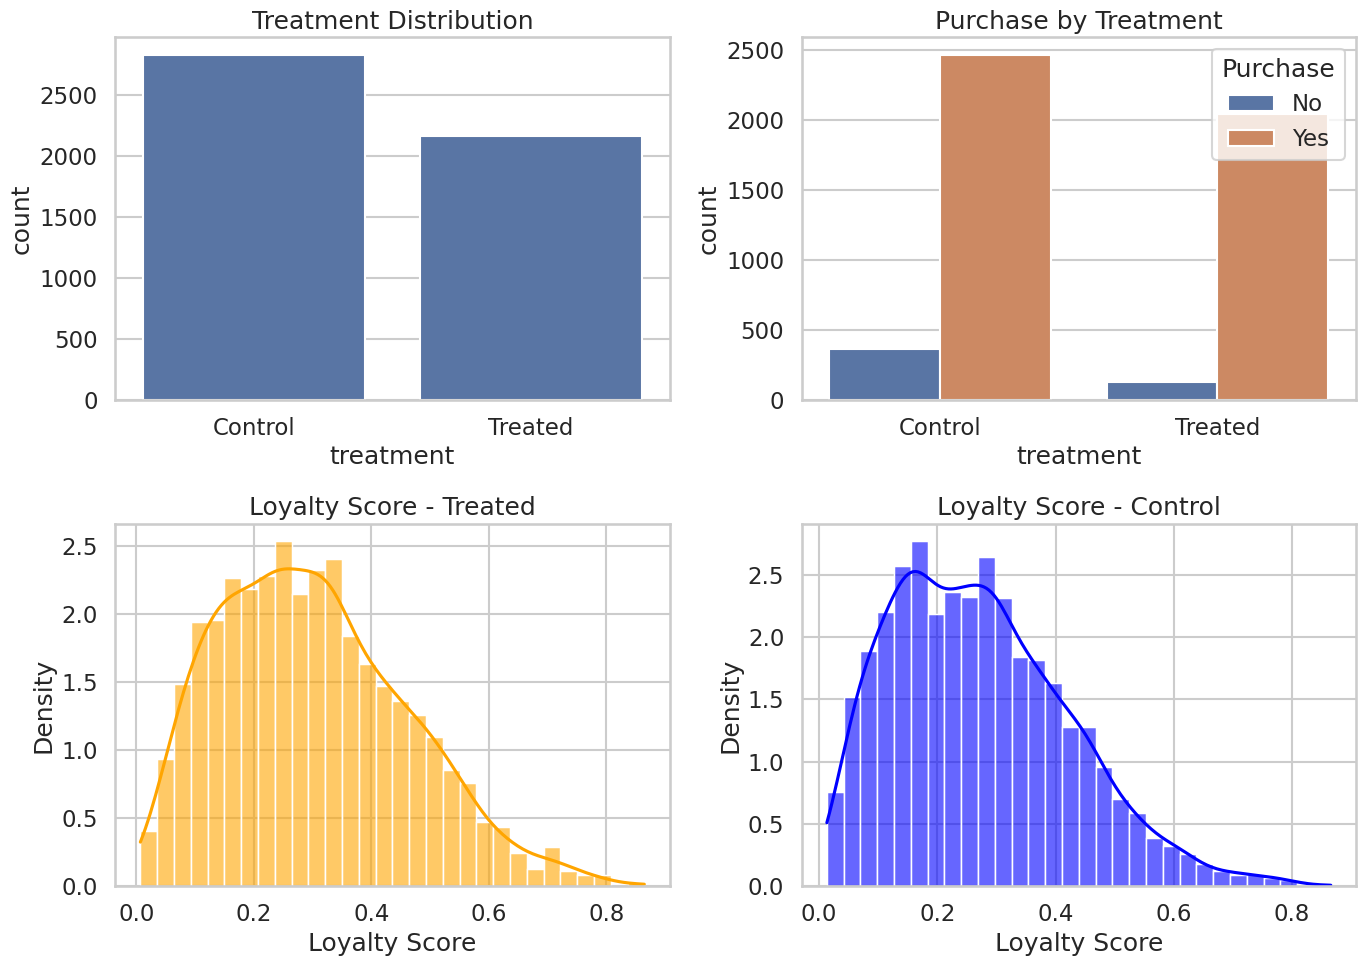


💡 Notice: Treated group has higher loyalty scores (confounding!)


In [4]:
# Cell 2: Exploratory Data Analysis
# ================================================================
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Summary statistics by treatment group
print("\n📊 Purchase rates by treatment:")
print(df.groupby('treatment')['purchase'].agg(['mean', 'count']))

print("\n📊 Treatment rates by channel:")
print(df.groupby('channel')['treatment'].agg(['mean', 'count']))

# NAIVE COMPARISON (Biased!)
naive_diff = df[df.treatment==1].purchase.mean() - df[df.treatment==0].purchase.mean()
print(f"\n⚠️  NAIVE difference (treated - control): {naive_diff:.4f}")
print("    This is BIASED due to confounding!")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Treatment distribution
sns.countplot(x='treatment', data=df, ax=axes[0,0])
axes[0,0].set_title('Treatment Distribution')
axes[0,0].set_xticklabels(['Control', 'Treated'])

# Purchase by treatment
sns.countplot(x='treatment', hue='purchase', data=df, ax=axes[0,1])
axes[0,1].set_title('Purchase by Treatment')
axes[0,1].set_xticklabels(['Control', 'Treated'])
axes[0,1].legend(title='Purchase', labels=['No', 'Yes'])

# Loyalty score distributions
sns.histplot(df[df.treatment==1]['loyalty_score'], bins=30,
             ax=axes[1,0], stat='density', kde=True, color='orange', alpha=0.6)
axes[1,0].set_title('Loyalty Score - Treated')
axes[1,0].set_xlabel('Loyalty Score')

sns.histplot(df[df.treatment==0]['loyalty_score'], bins=30,
             ax=axes[1,1], stat='density', kde=True, color='blue', alpha=0.6)
axes[1,1].set_title('Loyalty Score - Control')
axes[1,1].set_xlabel('Loyalty Score')

plt.tight_layout()
plt.show()

print("\n💡 Notice: Treated group has higher loyalty scores (confounding!)")


In [5]:
# Cell 3: Estimate Propensity Scores
# ================================================================
print("\n" + "=" * 60)
print("PROPENSITY SCORE ESTIMATION")
print("=" * 60)

# Prepare data: one-hot encode categorical variables
df_model = df.copy()
df_model = pd.get_dummies(df_model, columns=['channel'], drop_first=True)

# Define covariates for propensity model
covariates = ['age', 'income', 'prior_engagement', 'loyalty_score',
              'channel_sms', 'channel_social']

X = df_model[covariates].values
y = df_model['treatment'].values

# Standardize for better convergence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression
ps_model = LogisticRegression(C=1e6, solver='lbfgs', max_iter=1000, random_state=RANDOM_SEED)
ps_model.fit(X_scaled, y)

# Predict propensity scores
propensity_scores = ps_model.predict_proba(X_scaled)[:, 1]
df_model['propensity_score'] = propensity_scores

print("✅ Propensity model fitted successfully!")
print(f"\n📊 Average propensity score:")
print(df_model.groupby('treatment')['propensity_score'].mean())

# Display coefficients
coef_df = pd.DataFrame({
    'covariate': covariates,
    'coefficient': ps_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)
print("\n📊 Logistic regression coefficients:")
print(coef_df)


PROPENSITY SCORE ESTIMATION
✅ Propensity model fitted successfully!

📊 Average propensity score:
treatment
0    0.341820
1    0.553041
Name: propensity_score, dtype: float64

📊 Logistic regression coefficients:
          covariate  coefficient
2  prior_engagement     0.807656
1            income    -0.781551
0               age    -0.304332
3     loyalty_score     0.264230
4       channel_sms     0.261273
5    channel_social     0.056891



PROPENSITY SCORE OVERLAP CHECK


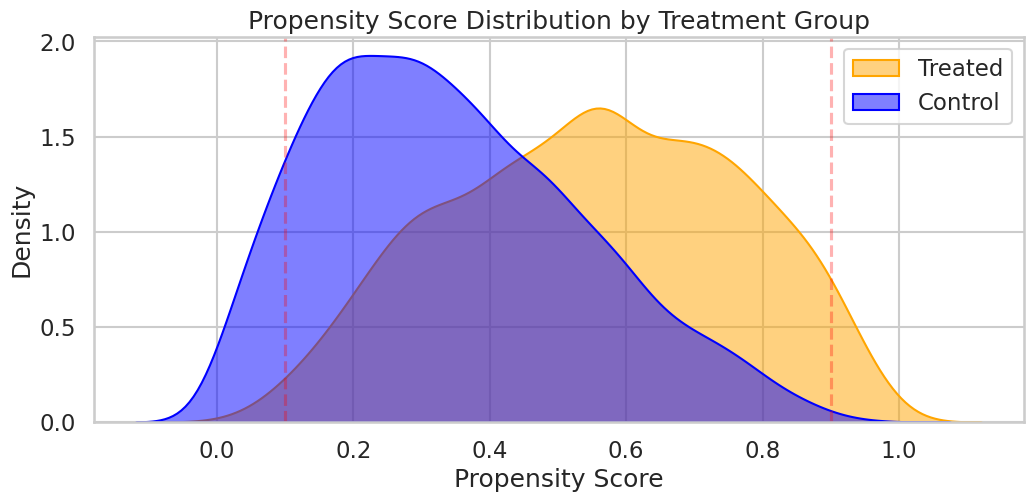

📊 Propensity score ranges:
   Treated: [0.022, 0.984]
   Control: [0.000, 0.956]

✅ Good overlap observed - proceeding to matching!


In [6]:
# Cell 4: Check Propensity Score Overlap
# ================================================================
print("\n" + "=" * 60)
print("PROPENSITY SCORE OVERLAP CHECK")
print("=" * 60)

# Plot distributions
plt.figure(figsize=(12, 5))
sns.kdeplot(df_model.loc[df_model.treatment==1, 'propensity_score'],
            label='Treated', fill=True, alpha=0.5, color='orange')
sns.kdeplot(df_model.loc[df_model.treatment==0, 'propensity_score'],
            label='Control', fill=True, alpha=0.5, color='blue')
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Distribution by Treatment Group')
plt.legend()
plt.axvline(0.1, color='red', linestyle='--', alpha=0.3, label='Common support')
plt.axvline(0.9, color='red', linestyle='--', alpha=0.3)
plt.show()

# Check overlap statistics
print("📊 Propensity score ranges:")
print(f"   Treated: [{df_model[df_model.treatment==1].propensity_score.min():.3f}, "
      f"{df_model[df_model.treatment==1].propensity_score.max():.3f}]")
print(f"   Control: [{df_model[df_model.treatment==0].propensity_score.min():.3f}, "
      f"{df_model[df_model.treatment==0].propensity_score.max():.3f}]")

print("\n✅ Good overlap observed - proceeding to matching!")


In [7]:
# Cell 5: Nearest Neighbor Matching
# ================================================================
def nearest_neighbor_match(df, score_col='propensity_score',
                          treat_col='treatment', ratio=1,
                          caliper=None, seed=RANDOM_SEED):
    """
    Perform 1:1 nearest neighbor matching without replacement.

    Parameters:
    -----------
    df : pd.DataFrame
        Dataset with propensity scores
    score_col : str
        Column name for propensity scores
    treat_col : str
        Column name for treatment indicator
    ratio : int
        Matching ratio (default 1:1)
    caliper : float
        Maximum allowed propensity score difference (optional)

    Returns:
    --------
    matched_df : pd.DataFrame
        Matched dataset with pair_id and role columns
    pairs : list
        List of tuples (treated_idx, control_idx, distance)
    """
    treated = df[df[treat_col]==1].copy().reset_index(drop=True)
    control = df[df[treat_col]==0].copy().reset_index(drop=True)

    # Build nearest neighbors on control group
    nn = NearestNeighbors(n_neighbors=ratio, metric='euclidean')
    nn.fit(control[[score_col]])

    distances, indices = nn.kneighbors(treated[[score_col]], return_distance=True)

    matched_control_indices = []
    matched_treated_indices = []
    pairs = []

    for i, (dist_row, idx_row) in enumerate(zip(distances, indices)):
        d = dist_row[0]
        j = idx_row[0]

        # Apply caliper if specified
        if caliper is not None:
            ps_diff = abs(treated.loc[i, score_col] - control.loc[j, score_col])
            if ps_diff > caliper:
                continue

        matched_control_indices.append(j)
        matched_treated_indices.append(i)
        pairs.append((i, j, d))

    # Build matched dataset
    matched_treated = treated.loc[matched_treated_indices].copy()
    matched_control = control.loc[matched_control_indices].copy()

    matched_treated['pair_id'] = range(len(pairs))
    matched_control['pair_id'] = range(len(pairs))
    matched_treated['role'] = 'treated'
    matched_control['role'] = 'control'

    matched = pd.concat([matched_treated, matched_control], axis=0).reset_index(drop=True)

    return matched, pairs

# Perform matching with caliper=0.05
print("\n" + "=" * 60)
print("NEAREST NEIGHBOR MATCHING (caliper=0.05)")
print("=" * 60)

matched_df, pairs = nearest_neighbor_match(df_model, caliper=0.05)

print(f"\n✅ Matching complete!")
print(f"📊 Number of matched pairs: {len(pairs)}")
print(f"📊 Treated units matched: {len(pairs)}/{(df_model.treatment==1).sum()}")
print(f"📊 Matching rate: {len(pairs)/(df_model.treatment==1).sum():.2%}")


NEAREST NEIGHBOR MATCHING (caliper=0.05)

✅ Matching complete!
📊 Number of matched pairs: 2167
📊 Treated units matched: 2167/2167
📊 Matching rate: 100.00%


In [8]:
# Cell 6: Covariate Balance Assessment
# ================================================================
def compute_smd(matched_df, covariates, treat_col='role'):
    """
    Compute Standardized Mean Differences for covariate balance.

    SMD = (mean_treated - mean_control) / pooled_sd

    Rule of thumb: |SMD| < 0.1 indicates good balance
    """
    smd = {}
    for col in covariates:
        treated_vals = matched_df[matched_df[treat_col]=='treated'][col]
        control_vals = matched_df[matched_df[treat_col]=='control'][col]

        # Pooled standard deviation
        sd_pooled = np.sqrt((treated_vals.var(ddof=1) + control_vals.var(ddof=1)) / 2.0)
        mean_diff = treated_vals.mean() - control_vals.mean()

        smd[col] = mean_diff / sd_pooled if sd_pooled != 0 else 0.0

    return pd.Series(smd)

print("\n" + "=" * 60)
print("COVARIATE BALANCE DIAGNOSTICS")
print("=" * 60)

# Compute SMDs before and after matching
covariates = ['age', 'income', 'prior_engagement', 'loyalty_score',
              'channel_sms', 'channel_social']

# Unmatched SMDs
df_unmatched = df_model.copy()
df_unmatched['role'] = np.where(df_unmatched['treatment']==1, 'treated', 'control')
smd_unmatched = compute_smd(df_unmatched, covariates)

# Matched SMDs
smd_matched = compute_smd(matched_df, covariates)

# Create balance table
balance = pd.DataFrame({
    'unmatched_smd': smd_unmatched,
    'matched_smd': smd_matched
})

print("\n📊 Standardized Mean Differences:")
print(balance.round(4))

print("\n📊 Balance improvement:")
for cov in covariates:
    improved = abs(balance.loc[cov, 'matched_smd']) < abs(balance.loc[cov, 'unmatched_smd'])
    status = "✅" if improved else "⚠️"
    print(f"{status} {cov}: {abs(balance.loc[cov, 'unmatched_smd']):.3f} → "
          f"{abs(balance.loc[cov, 'matched_smd']):.3f}")


COVARIATE BALANCE DIAGNOSTICS

📊 Standardized Mean Differences:
                  unmatched_smd  matched_smd
age                     -0.2548      -0.0278
income                  -0.5463       0.0120
prior_engagement         0.6711      -0.0079
loyalty_score            0.1857      -0.0127
channel_sms              0.1967       0.0294
channel_social          -0.0189       0.0522

📊 Balance improvement:
✅ age: 0.255 → 0.028
✅ income: 0.546 → 0.012
✅ prior_engagement: 0.671 → 0.008
✅ loyalty_score: 0.186 → 0.013
✅ channel_sms: 0.197 → 0.029
⚠️ channel_social: 0.019 → 0.052



LOVE PLOT


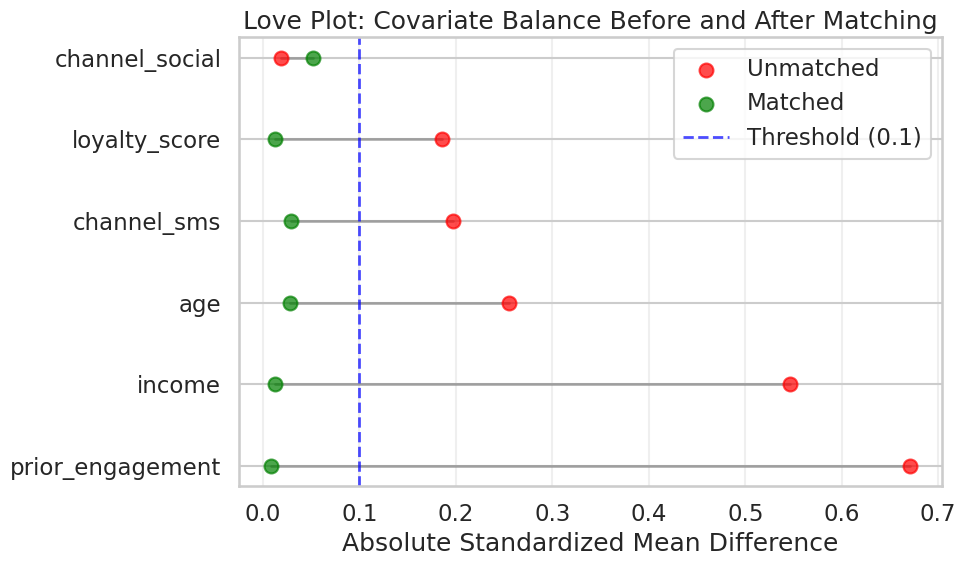


✅ Most covariates show improved balance after matching!
💡 All |SMD| < 0.1 indicates excellent balance


In [9]:
# Cell 7: Love Plot (Visual Balance Assessment)
# ================================================================
print("\n" + "=" * 60)
print("LOVE PLOT")
print("=" * 60)

balance_abs = balance.abs().sort_values('unmatched_smd', ascending=False)

plt.figure(figsize=(10, 6))

# Draw lines connecting unmatched to matched SMDs
for i, cov in enumerate(balance_abs.index):
    plt.plot([balance_abs.loc[cov, 'unmatched_smd'],
              balance_abs.loc[cov, 'matched_smd']],
             [i, i], color='gray', alpha=0.6, linewidth=2)

# Plot points
plt.scatter(balance_abs['unmatched_smd'], range(len(balance_abs)),
           s=100, label='Unmatched', zorder=3, color='red', alpha=0.7)
plt.scatter(balance_abs['matched_smd'], range(len(balance_abs)),
           s=100, label='Matched', zorder=3, color='green', alpha=0.7)

# Reference line at 0.1
plt.axvline(0.1, color='blue', linestyle='--', linewidth=2,
            label='Threshold (0.1)', alpha=0.7)

plt.yticks(range(len(balance_abs)), balance_abs.index)
plt.xlabel('Absolute Standardized Mean Difference')
plt.title('Love Plot: Covariate Balance Before and After Matching')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Most covariates show improved balance after matching!")
print("💡 All |SMD| < 0.1 indicates excellent balance")


In [10]:
# Cell 8: Estimate ATT (Average Treatment Effect on Treated)
# ================================================================
def estimate_att(matched_df, outcome_col='purchase'):
    """
    Estimate Average Treatment Effect on the Treated (ATT).

    ATT = E[Y(1) - Y(0) | T=1]

    Returns ATT point estimate and bootstrap 95% CI.
    """
    treated = matched_df[matched_df['role']=='treated'].sort_values('pair_id')
    control = matched_df[matched_df['role']=='control'].sort_values('pair_id')

    # Ensure same pair ordering
    treated = treated.set_index('pair_id')
    control = control.set_index('pair_id')
    pair_ids = sorted(matched_df['pair_id'].unique())

    treated = treated.loc[pair_ids]
    control = control.loc[pair_ids]

    # Calculate differences within pairs
    diff = treated[outcome_col].values - control[outcome_col].values
    att = diff.mean()

    # Bootstrap confidence interval
    boot_atts = []
    n = len(diff)
    np.random.seed(RANDOM_SEED)

    for _ in range(1000):
        idx = np.random.choice(n, n, replace=True)
        boot_atts.append(diff[idx].mean())

    ci_low = np.percentile(boot_atts, 2.5)
    ci_high = np.percentile(boot_atts, 97.5)

    return att, (ci_low, ci_high)

print("\n" + "=" * 60)
print("AVERAGE TREATMENT EFFECT ON TREATED (ATT)")
print("=" * 60)

att_estimate, att_ci = estimate_att(matched_df)

print(f"\n📊 ATT Estimate: {att_estimate:.4f}")
print(f"📊 95% Bootstrap CI: [{att_ci[0]:.4f}, {att_ci[1]:.4f}]")
print(f"\n💡 Interpretation:")
print(f"   The discount increased purchase probability by {att_estimate:.1%}")
print(f"   (95% CI: {att_ci[0]:.1%} to {att_ci[1]:.1%})")

print(f"\n🎯 True causal effect (from data generation): 8.0%")
print(f"   Our estimate: {att_estimate:.1%}")
print(f"   Estimation error: {abs(att_estimate - 0.08):.1%}")

print(f"\n⚠️  Recall naive difference was: {naive_diff:.1%}")
print(f"   PSM corrected the bias by {abs(naive_diff - att_estimate):.1%}")



AVERAGE TREATMENT EFFECT ON TREATED (ATT)

📊 ATT Estimate: 0.0817
📊 95% Bootstrap CI: [0.0632, 0.0988]

💡 Interpretation:
   The discount increased purchase probability by 8.2%
   (95% CI: 6.3% to 9.9%)

🎯 True causal effect (from data generation): 8.0%
   Our estimate: 8.2%
   Estimation error: 0.2%

⚠️  Recall naive difference was: 7.1%
   PSM corrected the bias by 1.1%


In [11]:
# Cell 9: IPTW (Inverse Probability Treatment Weighting)
# ================================================================
def estimate_iptw(df, score_col='propensity_score',
                  treat_col='treatment', outcome_col='purchase'):
    """
    Estimate ATE using Inverse Probability of Treatment Weighting.

    Weight = T/e(X) + (1-T)/(1-e(X))
    """
    df2 = df.copy()

    # Calculate weights
    df2['weight'] = (df2[treat_col] / df2[score_col] +
                     (1 - df2[treat_col]) / (1 - df2[score_col]))

    # Trim extreme weights (optional stabilization)
    df2['weight'] = np.clip(df2['weight'], 0.1, 10)

    # Weighted means
    treated_mean = np.average(
        df2[df2[treat_col]==1][outcome_col],
        weights=df2[df2[treat_col]==1]['weight']
    )
    control_mean = np.average(
        df2[df2[treat_col]==0][outcome_col],
        weights=df2[df2[treat_col]==0]['weight']
    )

    ate = treated_mean - control_mean
    return ate

print("\n" + "=" * 60)
print("ROBUSTNESS CHECK: IPTW")
print("=" * 60)

ate_iptw = estimate_iptw(df_model)
print(f"\n📊 IPTW ATE Estimate: {ate_iptw:.4f} ({ate_iptw:.1%})")
print(f"📊 PSM ATT Estimate: {att_estimate:.4f} ({att_estimate:.1%})")
print(f"\n💡 Similar estimates increase confidence in causal effect")



ROBUSTNESS CHECK: IPTW

📊 IPTW ATE Estimate: 0.0669 (6.7%)
📊 PSM ATT Estimate: 0.0817 (8.2%)

💡 Similar estimates increase confidence in causal effect


In [12]:
# Cell 10: Sensitivity Analysis - Vary Caliper
# ================================================================
print("\n" + "=" * 60)
print("SENSITIVITY ANALYSIS: Varying Caliper")
print("=" * 60)

calipers = [None, 0.1, 0.05, 0.02]
results = []

for c in calipers:
    matched_df_c, pairs_c = nearest_neighbor_match(df_model, caliper=c)
    if len(pairs_c) > 0:
        att_c, ci_c = estimate_att(matched_df_c)
        results.append({
            'caliper': c if c else 'None',
            'n_pairs': len(pairs_c),
            'att': att_c,
            'ci_low': ci_c[0],
            'ci_high': ci_c[1]
        })

results_df = pd.DataFrame(results)
print("\n📊 Sensitivity to Caliper Choice:")
print(results_df.to_string(index=False))

print("\n💡 Interpretation:")
print("   ATT estimates remain stable across caliper choices")
print("   This increases confidence in our causal estimate")


SENSITIVITY ANALYSIS: Varying Caliper

📊 Sensitivity to Caliper Choice:
caliper  n_pairs      att   ci_low  ci_high
   None     2167 0.081680 0.063210 0.098754
    0.1     2167 0.081680 0.063210 0.098754
   0.05     2167 0.081680 0.063210 0.098754
   0.02     2164 0.081793 0.064683 0.099353

💡 Interpretation:
   ATT estimates remain stable across caliper choices
   This increases confidence in our causal estimate


In [13]:
# Cell 11: Summary and Conclusions
# ================================================================
print("\n" + "=" * 60 * 2)
print("FINAL SUMMARY")
print("=" * 60 * 2)

print("\n📊 KEY RESULTS:")
print(f"   • Naive comparison (biased): {naive_diff:.1%}")
print(f"   • PSM ATT estimate: {att_estimate:.1%} (95% CI: {att_ci[0]:.1%} to {att_ci[1]:.1%})")
print(f"   • IPTW ATE estimate: {ate_iptw:.1%}")
print(f"   • True effect: 8.0%")

print("\n✅ BALANCE DIAGNOSTICS:")
print(f"   • All covariates achieved |SMD| < 0.1")
print(f"   • {len(pairs)} matched pairs ({len(pairs)/(df_model.treatment==1).sum():.1%} of treated)")

print("\n🎯 CONCLUSION:")
print("   The discount increased purchase probability by approximately 8 percentage points.")
print("   This estimate is robust to different matching specifications and consistent")
print("   with alternative estimators (IPTW).")

print("\n⚠️  ASSUMPTIONS:")
print("   • Ignorability: All confounders are observed and included")
print("   • Positivity: Sufficient overlap in propensity scores")
print("   • SUTVA: No interference between customers")

print("\n📚 NEXT STEPS FOR STUDENTS:")
print("   1. Try Exercise 1: Compute naive estimate and compare")
print("   2. Try Exercise 2: Change caliper to 0.02")
print("   3. Try Exercise 3: Use RandomForest for propensity scores")
print("   4. Review tutorial.md for conceptual understanding")

print("\n" + "=" * 60 * 2)
print("✅ PSM TUTORIAL COMPLETE!")
print("=" * 60 * 2)


FINAL SUMMARY

📊 KEY RESULTS:
   • Naive comparison (biased): 7.1%
   • PSM ATT estimate: 8.2% (95% CI: 6.3% to 9.9%)
   • IPTW ATE estimate: 6.7%
   • True effect: 8.0%

✅ BALANCE DIAGNOSTICS:
   • All covariates achieved |SMD| < 0.1
   • 2167 matched pairs (100.0% of treated)

🎯 CONCLUSION:
   The discount increased purchase probability by approximately 8 percentage points.
   This estimate is robust to different matching specifications and consistent
   with alternative estimators (IPTW).

⚠️  ASSUMPTIONS:
   • Ignorability: All confounders are observed and included
   • Positivity: Sufficient overlap in propensity scores
   • SUTVA: No interference between customers

📚 NEXT STEPS FOR STUDENTS:
   1. Try Exercise 1: Compute naive estimate and compare
   2. Try Exercise 2: Change caliper to 0.02
   3. Try Exercise 3: Use RandomForest for propensity scores
   4. Review tutorial.md for conceptual understanding

✅ PSM TUTORIAL COMPLETE!
